In [1]:

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F 
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:

class MNIST(Dataset):
    def __init__(self, src_path, transform=None):
        self.transform = transform
        df = pd.read_csv(src_path)
        y_np = df.iloc[:, 0].values
        X_np = df.iloc[:, 1:].values/255.0

        self.y = torch.from_numpy(y_np)
        X = torch.from_numpy(X_np)
        self.X = torch.reshape(X,(-1, 1, 28 ,28)).float()
    
    def __len__(self):
        assert len(self.y) == self.X.shape[0]
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X_sub = self.X[idx, :]
        y_sub = self.y[idx]

        if self.transform:
            X_sub = self.transform(X_sub)

        return X_sub, y_sub


In [4]:

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Linear(in_features=32*5*5, out_features=128)
        self.fc1 = nn.Linear(in_features=128, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)
    
    def forward(self, x):
        in_size = x.size(0)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.flatten(x))
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x)) ## this is the output layer.
        #x = F.log_softmax(x)        ## this is the logits layer.
        x = self.fc2(x)
        return x


In [5]:

loader = torch.load('../../data/models/dataloader.pth')
model = ConvNet()
model.load_state_dict(torch.load('../../data/models/convNet_torch.pt'))
model.to(device)


<All keys matched successfully>

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Linear(in_features=800, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

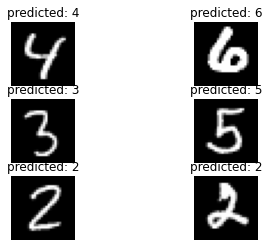

In [12]:

def visualize_model(model, num_images=6):
    # was_training = model.training
    model = model.eval()
    img_num = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, axis=1)

            for j in range(inputs.size()[0]):
                img_num += 1
                ax = plt.subplot(num_images//2, 2, img_num)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                plt.imshow(inputs.cpu().data[j].permute(1,2,0), cmap='gray')

                if img_num == num_images:
                    # model.train(mode=was_training)
                    return

visualize_model(model)
